In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
# import sumo as sm
import os
from traffic_initialization import *
import sys
from bs4 import BeautifulSoup
import tqdm
import pandas as pd

# New handy interface is here!
# Check interface.py for possible parameters
from interface import Simulation
%env SUMO_HOME=/usr/share/sumo
from datetime import datetime
%load_ext autotime

import concurrent.futures

env: SUMO_HOME=/usr/share/sumo
time: 68.3 µs (started: 2024-04-26 02:23:10 +03:00)


In [2]:
def single_simulation(index, seed, N, d0, d1, d2, d3=2, default_gap=3):
    sim = Simulation(start_road='E0', end_road='E2', default_gap=default_gap, N=N, work_dir=f'./xml_data/threading/thread{index}', net_data='test6.net.xml')
    sim.set_calibrator(road='E1', lane=['0'], gap=d0)
    sim.set_calibrator(road='E1', lane=['1'], gap=d1)
    sim.set_calibrator(road='E1', lane=['2'], gap=d2)
    sim.set_calibrator(road='E1', lane=['3'], gap=d3)
    sim.set_calibrator(road='E2', gap=1.5)
    sim.run(seed=seed)

    return sim.get_mean_throughput()

def throughput(N, d0, d1, d2, d3=2, default_gap=3, N_ave=12):
    
    seed_list = np.random.randint(-2**30, 2**30, N_ave)
    with concurrent.futures.ThreadPoolExecutor(max_workers=N_ave) as executor:
        futures = [executor.submit(single_simulation, index, seed, N, d0, d1, d2, d3, default_gap) 
                   for index, seed in enumerate(seed_list)]
        results = [future.result() for future in concurrent.futures.as_completed(futures)]   
    mean = np.mean(results)
    standart_deviation = np.std(results)
    
    return mean, standart_deviation

time: 800 µs (started: 2024-04-26 02:23:14 +03:00)


In [56]:
# new mean csv
while(True):

    d0 = np.random.rand()*30 + 20
    d1 = np.random.rand()*30 + 15
    d2 = np.random.rand()*5 + 1.5

    N = np.random.randint(4000, 6000)
    
    mean, _ = throughput(N=N, d0=d0, d1=d1, d2=d2, N_ave=12)

    filename='csv_data/test6_mean.csv'
    csv_data = pd.read_csv(filename)
    csv_data.loc[len(csv_data)] = (d0, d1, d2, N, mean)
    csv_data.to_csv(filename, index=False)

Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.


KeyboardInterrupt: 

time: 14h 38min 44s (started: 2024-04-26 02:54:02 +03:00)


# Evidance of effect existence

# Simple traffic without gap optimization

In [71]:
# calculation of throughput()
N_arr=np.linspace(10000, 100, 250)
out=np.zeros((250, 2))

for n in tqdm.tqdm(range(N_arr.shape[0])):
    
    out[n, :] = throughput(N_arr[n], 2, 2, 2, default_gap=2)
    
np.savez('res_data/simple_throughput_wide', out=out, N_arr=N_arr)

100%|██████████| 250/250 [39:40<00:00,  9.52s/it] 

time: 39min 40s (started: 2024-04-26 00:45:03 +03:00)


<function matplotlib.pyplot.show(close=None, block=None)>

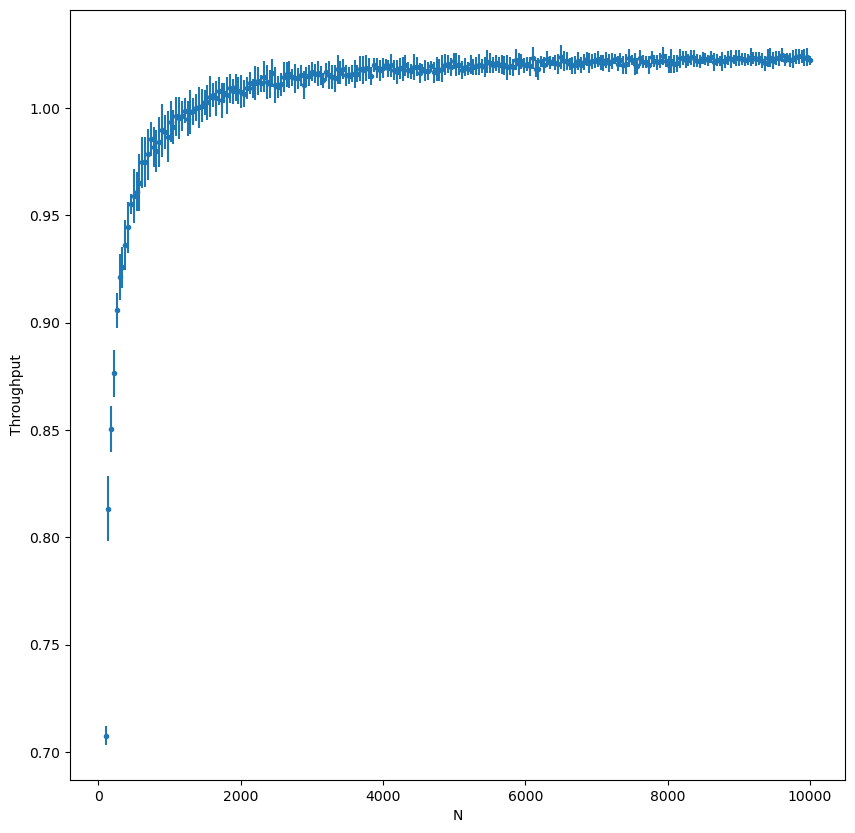

time: 74.6 ms (started: 2024-04-26 02:24:59 +03:00)


In [7]:
data = np.load('res_data/simple_throughput_wide.npz')

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10, 10)
ax.set_xlabel("N")
ax.set_ylabel("Throughput")

ax.errorbar(data['N_arr'], data['out'][:250, 0], yerr=np.asarray(data['out'][:250, 1]), linestyle="", marker=".")

plt.rcParams['font.size'] = '20'
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

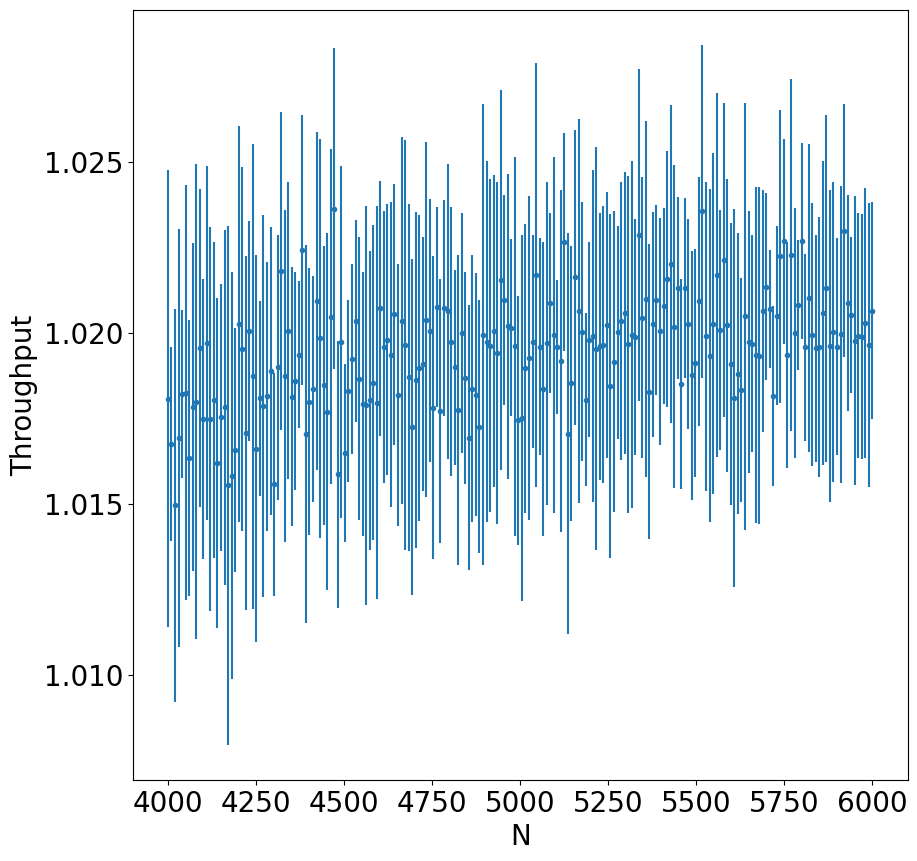

time: 80 ms (started: 2024-04-25 23:22:50 +03:00)


In [36]:
data = np.load('res_data/simple_throughput.npz')

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10, 10)
ax.set_xlabel("N")
ax.set_ylabel("Throughput")

ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".")

plt.rcParams['font.size'] = '20'
plt.show

# Optimization with annealing

In [64]:
def loss(d, N):

    mean, _ = throughput(N=N, d0=d[0], d1=d[0], d2=d[1], N_ave=12)

    filename='csv_data/test6_mean.csv'
    csv_data = pd.read_csv(filename)
    csv_data.loc[len(csv_data)] = (d[0], d[0], d[1], N, mean)
    csv_data.to_csv(filename, index=False)
    
    return -mean

time: 862 µs (started: 2024-04-26 00:34:09 +03:00)


In [ ]:
# simple optimization

N_arr = np.zeros(1)
opt_d = np.zeros((1, 2))

for n in tqdm.tqdm(range(1)):

    N = 4000 + n*150
    
    sol = sc.optimize.dual_annealing(loss, bounds=[(10, 40), (1.5, 30)], args=[N], maxiter=50, no_local_search=True)
    ans = sol.x

    opt_d[n, :] = ans
    N_arr[n] = N
    
    np.savez('res_data/annealing_res_wide', opt_d=opt_d, N_arr=N_arr)


In [84]:
# simple optimization

N_arr = np.zeros(1)
opt_d = np.zeros((1, 2))
opt_throughput = np.zeros(1)

for n in tqdm.tqdm(range(1)):

    N = 4000 + n*150
    
    sol = sc.optimize.dual_annealing(loss, bounds=[(10, 40), (1.5, 30)], args=[N], maxiter=50, no_local_search=True)
    ans = sol.x

    opt_d[n, :] = ans
    N_arr[n] = N
    opt_throughput[n] = -sol.fun
    
    np.savez('res_data/annealing_res', opt_d=opt_d, N_arr=N_arr)


100%|██████████| 1/1 [09:11<00:00, 551.23s/it]

time: 9min 11s (started: 2024-04-25 21:25:33 +03:00)


In [10]:
# dots for graph calc

data = np.load('res_data/annealing_res.npz')

opt_d = data['opt_d']

N_arr = data['N_arr']
out=np.zeros((N_arr.shape[0], 2))

for n in tqdm.tqdm(range(N_arr.shape[0])):
    
    out[n, :] = throughput(N_arr[n], opt_d[n, 0], opt_d[n, 0], opt_d[n, 1])
    
np.savez('res_data/annealing_throughput', out=out, N_arr=N_arr)

100%|██████████| 13/13 [00:51<00:00,  3.94s/it]

time: 51.2 s (started: 2024-04-26 02:35:40 +03:00)


<function matplotlib.pyplot.show(close=None, block=None)>

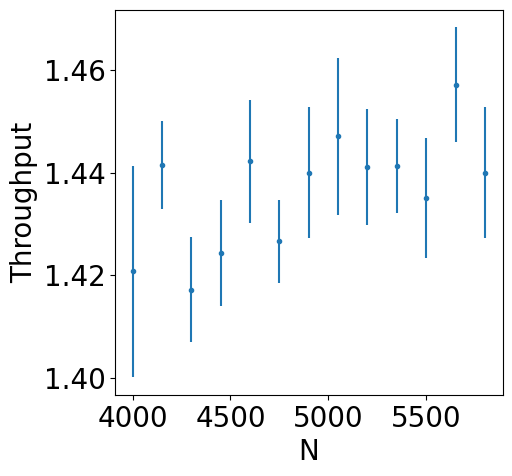

time: 54.9 ms (started: 2024-04-25 23:17:55 +03:00)


In [18]:
data=np.load('res_data/annealing_throughput.npz')

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (5, 5)
ax.set_xlabel("N")
ax.set_ylabel("Throughput")

ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".")

plt.rcParams['font.size'] = '20'
plt.show

# ML на основе бустинга
Тут есть два датасета:
    первый - состоит из значений troughput, посчитанных в случайных точках;
    второй - оптимизированный датасет, полученный из первого путем максимимзации значения throoughput

Далее обучаемся на каждом датасете и строим график для сравнения

In [9]:
from Some_models import OptimalDist
bad_data_filename = 'csv_data/test6.csv'
bad_res_filename = 'res_data/learn_data/bad_ML.npz'

good_data_filename = 'csv_data/test6_cleaned.csv'
good_res_filename = 'res_data/learn_data/good_ML.npz'

data_filenames = [bad_data_filename, good_data_filename]
res_filenames = [bad_res_filename, good_res_filename]

obj = OptimalDist()

for i in range(len(data_filenames)):
    obj.fit_data(data_filenames[i])
    inflow = np.arange(4000, 8001, 100)
    outflow = np.zeros((len(inflow), 2))
    
    for j, n in enumerate(inflow):
        d0, d1, d2 = obj.predict(n)[0]
        outflow[j, :] = (throughput(d0, d1, d2, n))
    np.savez(res_filenames[i], N_arr=inflow, out=outflow)

time: 1.45 ms (started: 2024-04-25 23:08:47 +03:00)


<function matplotlib.pyplot.show(close=None, block=None)>

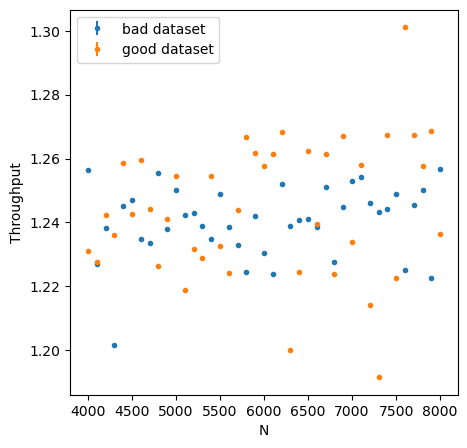

time: 71.5 ms (started: 2024-04-25 23:21:51 +03:00)


In [31]:
bad_data_filename = 'csv_data/test6.csv'
bad_res_filename = 'res_data/learn_data/bad_ML.npz'

good_data_filename = 'csv_data/test6_cleaned.csv'
good_res_filename = 'res_data/learn_data/good_ML.npz'

bad_data = np.load(bad_res_filename)
good_data = np.load(good_res_filename)

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (5, 5)
ax.set_xlabel("N")
ax.set_ylabel("Throughput")

ax.errorbar(bad_data['N_arr'], bad_data['out'][:, 0], yerr=np.asarray(0*bad_data['out'][:, 1]), linestyle="", marker=".", label='bad dataset')
ax.errorbar(good_data['N_arr'], good_data['out'][:, 0], yerr=np.asarray(0*good_data['out'][:, 1]), linestyle="", marker=".", label='good dataset')

plt.rcParams['font.size'] = '10'
plt.legend()
plt.show

# DL
Так как наша симуляция считается долго, то было решено написать нейроную сеть, которая будет предсказывать результаты симуляции

In [2]:
from Some_models import Throughput

obj = Throughput()
obj.fit('csv_data/test6.csv')

Epoch 1/10


2024-04-25 22:22:39.666522: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 394us/step - loss: 19891.2402 
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 2.1953
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - loss: 1.1412
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 0.1179
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 0.0452
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 0.0381
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 0.0383
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 0.0333
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 0.0297
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 0.0269
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - loss: 0.0284
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step - loss: 0.0282
MSE на обучающих данных: 0.028510767966508865
MSE на тестовых данных: 0.027932988479733467
time: 2.58 s (started: 2024-04-25 22:22:39 +03:00)


In [6]:
# simple throughput function with two gaps parameters

def throughput(d0, d1, d2, N):

    sim = Simulation(start_road='E0', end_road='E2', N=N, work_dir='./xml_data/test6', net_data='test6.net.xml')
    sim.set_calibrator(road='E0', gap=3)
    sim.set_calibrator(road='E1', lane=['0'], gap=d0)
    sim.set_calibrator(road='E1', lane=['1'], gap=d1)
    sim.set_calibrator(road='E1', lane=['2'], gap=d2)
    sim.set_calibrator(road='E1', lane=['3'], gap=2)
    sim.set_calibrator(road='E2', gap=1.5)
    sim.run()

    return sim.get_mean_throughput()

time: 298 µs (started: 2024-04-24 19:57:37 +03:00)


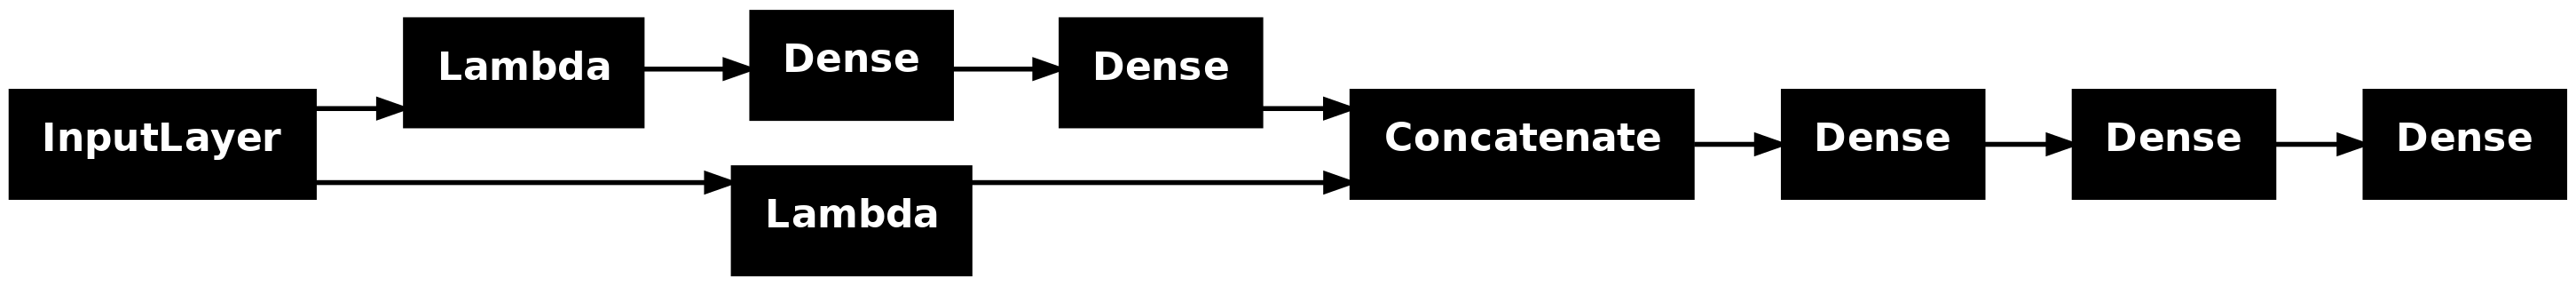

time: 81.6 ms (started: 2024-04-25 22:22:48 +03:00)


In [3]:
from tensorflow.keras.utils import plot_model
plot_model(obj.model, rankdir='LR')

# Summary

<function matplotlib.pyplot.show(close=None, block=None)>

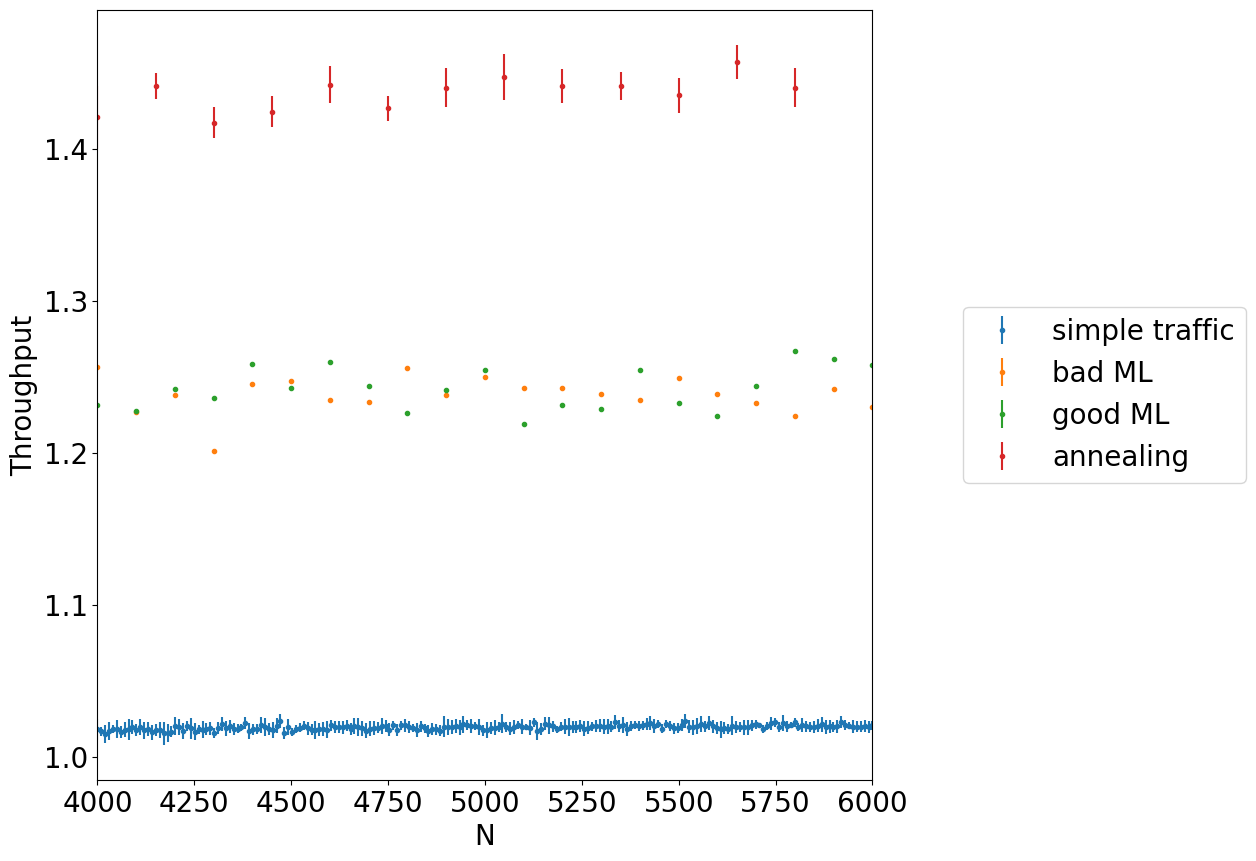

time: 91.6 ms (started: 2024-04-25 23:31:52 +03:00)


In [59]:
data = np.load('res_data/simple_throughput.npz')
bad_data_filename = 'csv_data/test6.csv'
bad_res_filename = 'res_data/learn_data/bad_ML.npz'

good_data_filename = 'csv_data/test6_cleaned.csv'
good_res_filename = 'res_data/learn_data/good_ML.npz'

fig, ax = plt.subplots()
plt.xlim([4000, 6000])
plt.rcParams["figure.figsize"] = (10, 10)
ax.set_xlabel("N")
ax.set_ylabel("Throughput")

ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".", label="simple traffic")
ax.errorbar(bad_data['N_arr'], bad_data['out'][:, 0], yerr=np.asarray(0*bad_data['out'][:, 1]), linestyle="", marker=".", label='bad ML')
ax.errorbar(good_data['N_arr'], good_data['out'][:, 0], yerr=np.asarray(0*good_data['out'][:, 1]), linestyle="", marker=".", label='good ML')

data=np.load('res_data/annealing_throughput.npz')
ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".", label='annealing')

plt.rcParams['font.size'] = '20'
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.5))
plt.show